In [1]:
import os, sys
import pandas as pd
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mdtraj as md
import scipy as sp

In [2]:
#Use this method if running from the notebooks folder otherwise comment out the following change:
os.chdir('../..')
cwd = os.getcwd()
DATA_PATH_ROOT = cwd
DATA_PATH = DATA_PATH_ROOT + '/data/arodz12/'
UNIPROT_ID = 'P00720'
DF_WT_SEQS = pd.read_csv(DATA_PATH + 'pw_dist_rmsd/' + UNIPROT_ID + '_wt.result')
PDBS = DF_WT_SEQS['pdb_id']
pdb_list = PDBS.tolist()
sns.set_style("darkgrid")

In [3]:
# Define functions
def get_chi1_angles(pdb):
        pdb = md.load_pdb(pdb)
        topology = pdb.topology
        table, bonds = topology.to_dataframe()
        ch1_pos, ch1_rad = md.compute_chi1(pdb)[0], md.compute_chi1(pdb)[1]
        chi_1_angles = np.degrees(ch1_rad)
        res = [table['resName'][ch1_pos[res][-1]] for res in range(len(ch1_pos))]
        n = [table['resSeq'][ch1_pos[res][-1]] for res in range(len(ch1_pos))]
        pos = [list(a) for a in zip(n,res)]
        return chi_1_angles, pos
    
def compile_angles_pdb(path):
    filenames = list()
    dir_list = sorted(os.listdir(path))
    angles_list = list()
    pos_list = list()
    for i in range(1,len(dir_list)):
        chi1_angle, pos = get_chi1_angles(path + dir_list[i])
        chi1_angle = chi1_angle.squeeze()
        angles_list.append(chi1_angle)
        filenames.append(dir_list[i])
        pdb = md.load_pdb(path + dir_list[i])
        topology = pdb.topology
        table, bonds = topology.to_dataframe()
        pos_list.append(pos)
    return angles_list, filenames, pos_list

# Load torsion angles for af 2
def compile_angles_af2(path, pdbs):
    filenames = list()
    dir_list = sorted(os.listdir(path))
    angles_list = list()
    pos_list = list()
    for k in range(len(dir_list)):
        for pdb in pdbs:
            if pdb in dir_list[k]:
                tmp_dir_list = os.listdir(path + '/' + dir_list[k])    
                pdb_file = [file for file in  tmp_dir_list if 'rank_1' in file and '.pdb' in file] 
                filenames.append(pdb_file[0])
                chi1_angle, pos = get_chi1_angles(path + '/' + dir_list[k] + '/' + pdb_file[0])
                chi1_angle = chi1_angle.squeeze()
                angles_list.append(chi1_angle)
                pos_list.append(pos)
    return angles_list, filenames, pos_list

def circ_meanscatter_plot(x_ls,y_ls):
    
    X = np.asarray(x_ls).ravel()
    X[X <= -120] += 360
    Y, Y_means = conv_to_np_arr_new(y_ls)
    print(X.shape, Y_means.shape)
    values = np.vstack((X, Y))
    print('herehere', values)
    #kernel = gaussian_kde(values)
    #kde = kernel.evaluate(values)
    #norm = Normalize(vmin=kde.min(), vmax=kde.max())
    #colors = cm.ScalarMappable(norm=norm, cmap='viridis_r').to_rgba(kde)
    plt.title('P00720',fontsize=12)
    plt.xlabel('$\chi_1$ AF2 [$^\circ$]',fontsize=12)
    plt.ylabel('$\chi_1$ X-ray [$^\circ$]',fontsize=12)
    plt.xlim(-120,250)
    plt.ylim(-120,250)
    trend = np.polyfit(X,Y_means,1)
    trendpoly = np.poly1d(trend) 
    plt.scatter(X, Y_means)#, c=colors)
    plt.plot(X,trendpoly(X), c='black', label = 'ρ = 0.87')
    plt.legend(fontsize=14, loc="upper left")
    plt.legend(fontsize=14, loc="upper left")
    plt.savefig(DATA_PATH_ROOT + "/notebooks/figs/chi1_plot_P00720-wt.png", dpi=1200)
    
    print(X.shape, Y_means.shape)
    return correlations_vector(X, Y_means)

def conv_to_np_arr_new(list_angles):
    mean_angles = np.array([])
    max_val = 138 #max(len(elem) for elem in list_angles)
    tmp_list = list()
    if len(list_angles) != 138:
        for i in range(len(list_angles)):
            len_ls = len(list_angles[i])
            if len_ls > 138:
                continue
            elif len_ls <= max_val:
                arr_2nan = np.empty((1,max_val-len_ls))
                arr_2nan[:] = 0
                list_angles[i] = np.append(list_angles[i],arr_2nan)
                tmp_list.append(list_angles[i])
    
    list_angles = tmp_list
    degs =  np.vstack((list_angles))
    #print('here here: ', degs[degs < -120])
    av_sin = np.mean(np.sin(degs * np.pi / 180.),axis=0)
    av_cos = np.mean(np.cos(degs * np.pi / 180.),axis=0)
    mean_angles = np.rad2deg(np.arctan2(av_sin,av_cos))
    mean_angles[mean_angles <= -120] += 360
    return list_angles, mean_angles

def correlations_vector(score1, score2):
    # Declaring y and x to append mave_data comp_data, respectively.
    y=[]; x=[]
    # Looping through NaNs and inly appending non NaNs to y and x
    for i in range(score1.shape[0]):
        if np.isnan(score1[i]) or np.isnan(score2[i]):
            pass
        else:
            x.append(float(score1[i]))
            y.append(float(score2[i]))
    # Converting to np arrays and calculating pearson and spearman correalation.
    x=np.array(x)
    y=np.array(y)
    r=sp.stats.pearsonr(x,y)
    s,p=sp.stats.spearmanr(x,y)
    print("Pearson's correlation coefficient between data: ",abs(r[0]))
    print("Spearman's correlation coefficient bewteen data: " ,abs(s))

    return [abs(r[0]),abs(s)]

In [4]:
def download_pdb(pdbcode, datadir, downloadurl="https://files.rcsb.org/download/"):
    """
    Downloads a PDB file from the Internet and saves it in a data directory.
    :param pdbcode: The standard PDB ID e.g. '3ICB' or '3icb'
    :param datadir: The directory where the downloaded file will be saved
    :param downloadurl: The base PDB download URL, cf.
        `https://www.rcsb.org/pages/download/http#structures` for details
    :return: the full path to the downloaded PDB file or None if something went wrong
    """
    pdbfn = pdbcode + ".pdb"
    url = downloadurl + pdbfn
    outfnm = os.path.join(datadir, pdbfn)
    try:
        urllib.request.urlretrieve(url, outfnm)
        return outfnm
    except Exception as err:
        print(str(err), file=sys.stderr)
        return None


In [5]:
# Downlaod structures
#for i in range(len(PDBS)): # exclude NaN [-1]
#    print(PDBS[i])
#    download_pdb(PDBS[i], DATA_PATH + 'pdbs_wt_P00720/')

In [6]:
DF_WT_RMSD = pd.read_csv(DATA_PATH + 'pw_dist_rmsd/' + 'rmsd_wt_' + UNIPROT_ID + '.csv')
DF_WT_RMSD

,rmsd
0,0.125405
1,0.172905
2,0.053855
3,0.136350
4,0.114875
5,0.159816


<AxesSubplot:xlabel='rmsd', ylabel='Count'>

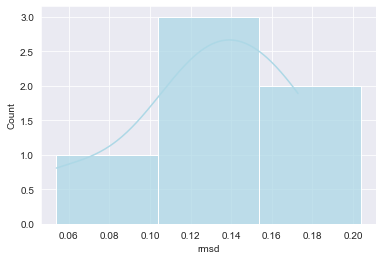

In [7]:
sns.histplot(DF_WT_RMSD, x="rmsd", binwidth=0.05, alpha=0.75, kde=True, color='lightblue', label="WT: $\mu = {}$, $\sigma = {}$".format(round(DF_WT_RMSD["rmsd"].mean(),3),round(DF_WT_RMSD["rmsd"].std(),3)))

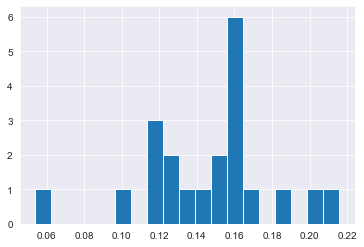

(7, 7)
(21,)
[[0.         0.12540532 0.17290501 0.05385482 0.1363501  0.11487465
  0.159816  ]
 [0.12540532 0.         0.15780416 0.11404232 0.1452456  0.1494643
  0.16277569]
 [0.17290501 0.15780416 0.         0.1540997  0.18181259 0.16354131
  0.21586554]
 [0.05385482 0.11404232 0.1540997  0.         0.12679101 0.10240861
  0.15819363]
 [0.1363501  0.1452456  0.18181259 0.12679101 0.         0.16408846
  0.11551699]
 [0.11487465 0.1494643  0.16354131 0.10240861 0.16408846 0.
  0.20357356]
 [0.159816   0.16277569 0.21586554 0.15819363 0.11551699 0.20357356
  0.        ]]


In [8]:
W = np.load(DATA_PATH + 'pw_dist_rmsd/' + 'M_P00720_wt.npy')
W_u = np.unique(np.triu(W, k=0))[1:]
num_bins = 20 # <-- Change here - Specify total number of bins for histogram
plt.hist(W_u.ravel(), bins=np.linspace(np.min(W_u), np.max(W_u), num=num_bins)) #<-- Change here.  Note the use of ravel.
plt.show()
W_u
print(W.shape)
print(W_u.shape)
print(W)

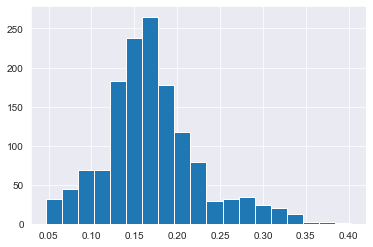

In [9]:
M =np.load(DATA_PATH + 'pw_dist_rmsd/' + 'M_pair_P00720_mut.npy')
M_u = np.unique(np.triu(M, k=0))[1:] # <-- Get upper triangle of symmetric matrix
num_bins = 20 
plt.hist(M_u.ravel(), bins=np.linspace(np.min(M_u), np.max(M_u), num=num_bins)) 
plt.show()

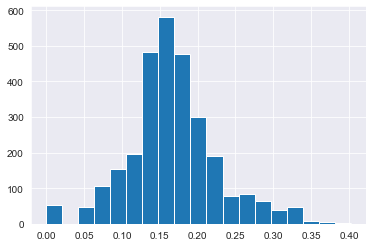

In [10]:
M =np.load(DATA_PATH + 'pw_dist_rmsd/' + 'M_pair_P00720_mut.npy')
num_bins = 20  
plt.hist(M.ravel(), bins=np.linspace(np.min(M), np.max(M), num=num_bins))
plt.show()

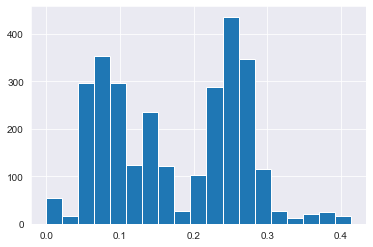

In [11]:
A =np.load(DATA_PATH + 'pw_dist_rmsd/' + 'M_pair_P00720_mut_af2.npy')
num_bins = 20  
plt.hist(A.ravel(), bins=np.linspace(np.min(A), np.max(A), num=num_bins))
plt.show()

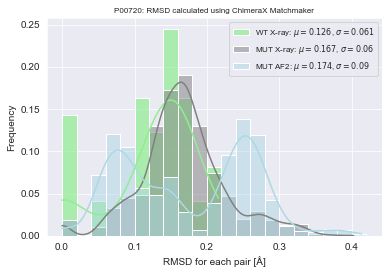

In [12]:
df_W = pd.DataFrame(W.ravel(), columns=['rmsd'])
df_M = pd.DataFrame(M.ravel(), columns=['rmsd'])
df_A = pd.DataFrame(A.ravel(), columns=['rmsd'])
sns.histplot(df_W, x="rmsd", binwidth=0.02, alpha=0.7, kde=True, color='lightgreen', label="WT X-ray: $\mu = {}$, $\sigma = {}$".format(round(df_W["rmsd"].mean(),3),round(df_W["rmsd"].std(),3)), stat = "probability")
sns.histplot(df_M, x="rmsd", binwidth=0.02, alpha=0.5, kde=True, color='grey', label="MUT X-ray: $\mu = {}$, $\sigma = {}$".format(round(df_M["rmsd"].mean(),3),round(df_M["rmsd"].std(),3)), stat = "probability")
sns.histplot(df_A, x="rmsd", binwidth=0.02, alpha=0.5, kde=True, color='lightblue', label="MUT AF2: $\mu = {}$, $\sigma = {}$".format(round(df_A["rmsd"].mean(),3),round(df_A["rmsd"].std(),3)), stat = "probability")

plt.legend(fontsize=8)
plt.title('P00720: RMSD calculated using ChimeraX Matchmaker',fontsize=8)
plt.xlabel("RMSD for each pair [Å]")
plt.ylabel("Frequency")

plt.savefig(DATA_PATH_ROOT + "/notebooks/figs/pairwise_wt_xray_mut_xray_mut_af2_P00720.pdf")
plt.show()

In [24]:
df_A.describe()

,rmsd
count,2916.000000
mean,0.173668
std,0.090269
min,0.000000
25%,0.087514
50%,0.164186
75%,0.252731
max,0.413281


In [13]:
m_arr = df_M['rmsd'].to_numpy()
a_arr = df_A['rmsd'].to_numpy()

In [14]:
m_arr[m_arr > 0.3].shape

(90,)

In [15]:
a_arr[a_arr > 0.3].shape

(114,)

In [16]:
M_high_vars = [[0.36710592935666, '1l06', '1l53'], [0.3501804286990137, '1l06', '1l99'], [0.3671059293566586, '1l53', '1l06'], [0.40225855221994516, '1l53', '1l60'], [0.4022585522199471, '1l60', '1l53'], [0.37596760885194336, '1l60', '1l99'], [0.35018042869901317, '1l99', '1l06'], [0.3759676088519438, '1l99', '1l60']]

In [17]:
A_high_vars = [[0.3840732476013865, '1dyb', '1l99'], [0.38318749835947435, '1dyc', '1l99'], [0.35713484744318175, '1dye', '1l99'], [0.3932828286366337, '1dyg', '1l99'], [0.39171187106557975, '1l02', '1l99'], [0.37224051297857025, '1l03', '1l99'], [0.35147972695691243, '1l05', '1l99'], [0.37577021296510277, '1l08', '1l99'], [0.3656907181072483, '1l09', '1l99'], [0.35834801712331993, '1l10', '1l99'], [0.40648510067623295, '1l11', '1l99'], [0.38286413486140863, '1l12', '1l99'], [0.3777356946308998, '1l13', '1l99'], [0.3716140500665661, '1l14', '1l99'], [0.3650882191878062, '1l15', '1l99'], [0.36180582889675633, '1l16', '1l99'], [0.3843229462178809, '1l19', '1l99'], [0.3795646577415588, '1l22', '1l99'], [0.3685518654512525, '1l27', '1l99'], [0.39590544945617956, '1l28', '1l99'], [0.40374524736165485, '1l31', '1l99'], [0.4132808963692479, '1l32', '1l99'], [0.3943253575351221, '1l46', '1l99'], [0.3745269310193404, '1l47', '1l99'], [0.39009593765134876, '1l52', '1l99'], [0.3574309770778443, '1l53', '1l99'], [0.3673991242368709, '1l57', '1l99'], [0.3986695254398935, '1l69', '1l99'], [0.37533497718903613, '1l98', '1l99'], [0.3840732476013864, '1l99', '1dyb'], [0.38318749835947435, '1l99', '1dyc'], [0.3571348474431819, '1l99', '1dye'], [0.39328282863663366, '1l99', '1dyg'], [0.39171187106558, '1l99', '1l02'], [0.37224051297857047, '1l99', '1l03'], [0.3514797269569131, '1l99', '1l05'], [0.3757702129651027, '1l99', '1l08'], [0.36569071810724807, '1l99', '1l09'], [0.3583480171233202, '1l99', '1l10'], [0.4064851006762329, '1l99', '1l11'], [0.38286413486140874, '1l99', '1l12'], [0.37773569463089995, '1l99', '1l13'], [0.3716140500665661, '1l99', '1l14'], [0.365088219187806, '1l99', '1l15'], [0.3618058288967563, '1l99', '1l16'], [0.38432294621788055, '1l99', '1l19'], [0.37956465774155895, '1l99', '1l22'], [0.36855186545125274, '1l99', '1l27'], [0.39590544945617967, '1l99', '1l28'], [0.4037452473616553, '1l99', '1l31'], [0.41328089636924775, '1l99', '1l32'], [0.39432535753512216, '1l99', '1l46'], [0.3745269310193409, '1l99', '1l47'], [0.39009593765134876, '1l99', '1l52'], [0.35743097707784427, '1l99', '1l53'], [0.3673991242368709, '1l99', '1l57'], [0.3986695254398932, '1l99', '1l69'], [0.3753349771890361, '1l99', '1l98']]

In [18]:
df_sig_af2 = pd.read_csv(DATA_PATH_ROOT + '/data/arodz12/pw_dist_rmsd/signi_rmsd_paris.csv')

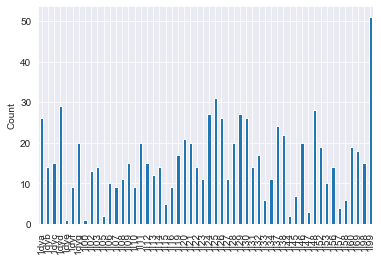

In [19]:
# We use double the wild type mean to filter for mutants changes that are different than wild type
df_sig_af2['pdb1']
df_sig_af2['pdb2']
occur = df_sig_af2.groupby(['pdb2']).size()
occur
ax = occur.plot.bar(x='lab', y='val')
ax.set_xlabel("")
ax.set_ylabel("Count")
plt.savefig(DATA_PATH_ROOT + "/notebooks/figs/bar_chart_pair_rmsd_af2_P00720.pdf")

In [20]:
occur

pdb2
1dya    26
1dyb    14
1dyc    15
1dyd    29
1dye     1
1dyf     9
1dyg    20
1l00     1
1l02    13
1l03    14
1l05     2
1l06    10
1l07     9
1l08    11
1l09    15
1l10     9
1l11    20
1l12    15
1l13    12
1l14    14
1l15     5
1l16     9
1l19    17
1l20    21
1l21    20
1l22    14
1l23    11
1l24    27
1l25    31
1l26    26
1l27    11
1l28    20
1l29    27
1l30    26
1l31    14
1l32    17
1l33     6
1l34    11
1l37    24
1l38    22
1l44     2
1l45     7
1l46    20
1l47     3
1l48    28
1l52    19
1l53    10
1l56    14
1l57     4
1l58     6
1l60    19
1l69    18
1l98    15
1l99    51
dtype: int64

In [21]:
df_sig_pdb = pd.read_csv(DATA_PATH_ROOT + '/data/arodz12/pw_dist_rmsd/signi_rmsd_pairs_pdb.csv')
df_sig_pdb['pdb1'].unique()
df_sig_pdb['pdb2'].unique()
df_sig_pdb
occur = df_sig_pdb.groupby(['pdb2']).size()
occur

pdb2
1dya     1
1dyc     2
1dyd     1
1dye     1
1dyf     1
1dyg     1
1l00    19
1l02     4
1l03     2
1l05     4
1l06     4
1l07     4
1l08     4
1l09     4
1l10     4
1l11     2
1l12     4
1l13     4
1l14     4
1l15     4
1l16     4
1l19     2
1l20     2
1l21     3
1l22     2
1l23     2
1l24     2
1l25     3
1l26     2
1l27     2
1l28     2
1l29     4
1l30     2
1l31     5
1l32     2
1l33     4
1l34     4
1l37     2
1l38     2
1l44     2
1l46     2
1l47     3
1l48     3
1l52     2
1l53    45
1l57     2
1l58     2
1l60     9
1l69     1
1l98    17
1l99    41
dtype: int64

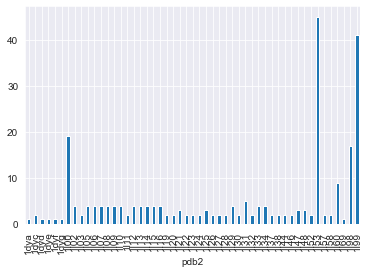

In [22]:
df_W.describe()
ax = occur.plot.bar(x='lab', y='val')
plt.savefig(DATA_PATH_ROOT + "/notebooks/figs/bar_chart_pair_rmsd_pdb_P00720.png", dpi=1200)

In [24]:
# Get chi 1 angles
DATA_PATH_PDB_WT = DATA_PATH + 'pdbs_wt_P00720/'
DATA_PATH_AF2_WT = DATA_PATH_ROOT + '/data/results_af2/P00720'

wt = ['2lzm']
chi_1_pdb, filenames_pdb, pos_pdb = compile_angles_pdb(DATA_PATH_PDB_WT)
chi_1_af2, filenames_af2, pos_af2 = compile_angles_af2(DATA_PATH_AF2_WT,wt)